# Automated Hate Speech Detection in Reddit Platform

In [1]:
!pip install emoji

In [2]:
!pip install demoji

In [3]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preprocessing

### Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import demoji
import emoji

### Analyze the Dataset

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Original_Reddit.csv')

In [6]:
df.head()

,id,text,hate_speech_idx,response
0,1. e8q18lf\n2. \te8q9w5s\n3. \t\te8qbobk\n4. \...,1. A subsection of retarded Hungarians? Ohh bo...,[1],"[""I don't see a reason why it's okay to insult..."
1,1. e9c6naz\n2. \te9d03a5\n3. \t\te9d8e4d\n,"1. > ""y'all hear sumn?"" by all means I live i...",[3],['Persons with disabilities is the accepted te...
2,1. e84rl2i\n2. \te84w60l\n3. \t\te8544rn\n4. \...,1. wouldn't the defenders or whatever they are...,NaN,NaN
3,1. e7kq72n\n2. \te7m24ar\n,1. Because the Japanese aren't retarded and kn...,[1],"[""It's not right for anyone of any gender to b..."
4,1. e7hdgoh\n2. \te7iyj6a\n3. \t\te7j6iho\n4. \...,1. That might be true if we didn't have an exa...,"[2, 3]","[""You shouldn't be bringing up sensitive topic..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5020 non-null   object
 1   text             5020 non-null   object
 2   hate_speech_idx  3847 non-null   object
 3   response         3847 non-null   object
dtypes: object(4)
memory usage: 157.0+ KB


#### Each row of text contains more than 1 comment.

In [8]:
df['text'][17]

'1. Grammatical errors, overt racism, child prostitution.. It would appear we have a despicable moron on our hands. \n'

In [9]:
df['text'][1]

'1. > "y\'all hear sumn?"  by all means I live in a small town rn (for work). 5k people here, originally a mining community. No one is protesting here. Nobody mentioned the protest today. Nobody here cares, they\'re busy loving their family and working hard.  Thank god for the electoral college. Liberals think we don\'t matter. \n2. \t[removed]\n3. \t\tah a liberal has slipped in. you can tell because the first question asked was loaded and retarded.  >  What does "working hard" mean? Your political views get more validated by how much manual labour you put in?   where did I say that? and yes, of course you have no clue what "working hard" means. Few soyboys do.  > Based on your comment regarding the EC I guess you don\'t really think that 2 mil majority of people who voted for Hillary don\'t really matter.  I shouldn\'t have to explain to you the point of the EC. If you want to talk to someone who is more patient with you than I am, you can check out AskThe_Donald. \n'

#### The corresponding hate speech index determines which comments are categorized as hate speech.

In [10]:
df['hate_speech_idx'][17]

nan

In [11]:
df['hate_speech_idx'][1]

'[3]'

#### Statistics

In [12]:
df['text'].describe()

count                   5020
unique                  5002
top       1. What a cunt. \n
freq                       4
Name: text, dtype: object

In [13]:
df['hate_speech_idx'].describe()

count     3847
unique     316
top        [1]
freq      1740
Name: hate_speech_idx, dtype: object

In [14]:
df.describe()

,id,text,hate_speech_idx,response
count,5020,5020,3847,3847
unique,5015,5002,316,3838
top,1. e9ai3dh\n,1. What a cunt. \n,[1],"[""You're disturbingly obsessed with women."", '..."
freq,2,4,1740,3


### Restructuring the Dataset

#### Restructuring the dataset to have individual rows for each comment from a post, tagging them with a 1 if they contain hate speech and 0 if not.

In [15]:
# Function to split comments and mark hate speech
def process_comments(row):
    # Using regex to find the pattern "index. comment"
    pattern = re.compile(r'(\d+)\.\s(.*?)(?=\d+\.\s|$)', re.DOTALL)
    matches = pattern.findall(row['text'])

    # Clean and split the hate_speech_idx column
    hate_indices = list(map(int, re.sub(r'[^0-9,]', '', row['hate_speech_idx']).split(','))) if pd.notna(row['hate_speech_idx']) else []

    processed_data = []

    for index, comment in matches:
        index = int(index)
        comment = comment.strip()
        is_hate_speech = 1 if index in hate_indices else 0
        processed_data.append([index, comment, is_hate_speech])

    return processed_data

processed_comments = df.apply(process_comments, axis=1)
processed_comments = [item for sublist in processed_comments for item in sublist]
new_df = pd.DataFrame(processed_comments, columns=['index','comment', 'hate_speech'])

In [16]:
new_df.to_csv('/content/drive/MyDrive/Restructure_Reddit.csv', index=False)
print("File Saved")

File Saved


### Import Restructured Dataset

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Restructure_Reddit.csv')
print("Column names:", df.columns)

Column names: Index(['index', 'comment', 'hate_speech'], dtype='object')


In [18]:
df.head()

,index,comment,hate_speech
0,1,A subsection of retarded Hungarians? Ohh boy. ...,1
1,2,Hiii. Just got off work. 444 is mainly the typ...,0
2,3,wow i guess soyboys are the same in every country,0
3,4,Owen Benjamin's soyboy song goes for every cou...,0
4,1,"> ""y'all hear sumn?"" by all means I live in a...",0


In [19]:
df = df.drop(columns=['index'])

In [20]:
df.head()

,comment,hate_speech
0,A subsection of retarded Hungarians? Ohh boy. ...,1
1,Hiii. Just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,Owen Benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means I live in a...",0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22841 entries, 0 to 22840
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      22757 non-null  object
 1   hate_speech  22841 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 357.0+ KB


In [22]:
df.describe()

,hate_speech
count,22841.000000
mean,0.231864
std,0.422032
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


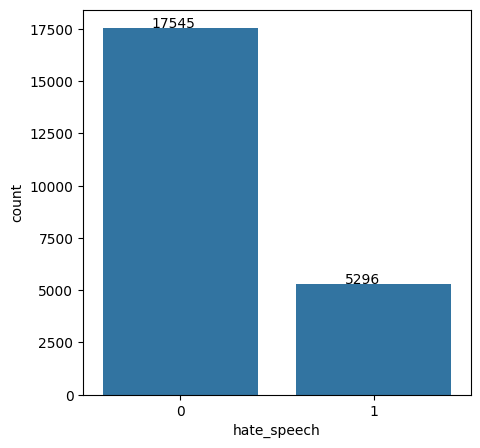

In [23]:
plt.figure(figsize=(5,5))
ax=sns.countplot(x=df['hate_speech'],data=df,order=df['hate_speech'].value_counts().index)
for p,label in zip(ax.patches,df['hate_speech'].value_counts()):
    ax.annotate(label,(p.get_x()+0.25,p.get_height()+0.5))

### Data Cleaning

#### Remove NaN values and drop comments which are deleted or removed

In [24]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22841
Comment Count:  22757
Hate Speech Length:  22841
Hate Speech Count:  22841


In [25]:
df = df.dropna().loc[(df['comment'] != '[deleted]') & (df['comment'] != '[removed]')]

In [26]:
size_col0 = len(df['comment'])
size_col1 = df['comment'].count()
size_col2 = len(df['hate_speech'])
size_col3 = df['hate_speech'].count()
print("Comment Length: ", size_col0)
print("Comment Count: ", size_col1)
print("Hate Speech Length: ", size_col2)
print("Hate Speech Count: ",size_col3)

Comment Length:  22246
Comment Count:  22246
Hate Speech Length:  22246
Hate Speech Count:  22246


### Convert to lowercase


#### In tokenization a sentence word by word, same word represented in upper and lower case notations are identified as different words. For example, ‘Basic’ and ‘basic’ are considered different but they both are same,because python is case-sensitive,it adds complexity to model, to simplify it we do lowercasing.

In [27]:
df['comment'][1]

'Hiii. Just got off work. 444 is mainly the typa guys you imagine writing for US stupid sites, but basically they just try to fit in with the Western European and US big city hipsters.   Rich kids from Budapest who feel they are brave journalistic heroes.'

In [28]:
df['comment']=df['comment'].str.lower()
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a...",0


In [29]:
df['comment'][1]

'hiii. just got off work. 444 is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters.   rich kids from budapest who feel they are brave journalistic heroes.'

### Remove Extra Spaces

#### While analyzing text data for classification or other types of analysis, it's essential to ensure the text is clean and well-formatted. Extra spaces, whether between words or at the beginning and end of the text, can lead to inconsistencies and affect the performance of text processing algorithms. Removing these extra spaces helps standardize the text, making it more suitable for analysis.

In [30]:
df['comment'][1]

'hiii. just got off work. 444 is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters.   rich kids from budapest who feel they are brave journalistic heroes.'

In [31]:
def clean_spaces(text):
    if isinstance(text, str):
        # Remove multiple consecutive spaces and trim leading/trailing spaces
        text = ' '.join(text.split())
    return text

df['comment'] = df['comment'].apply(clean_spaces)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


In [32]:
df['comment'][1]

'hiii. just got off work. 444 is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters. rich kids from budapest who feel they are brave journalistic heroes.'

### Removing HTML Tags

#### Removing unwanted data from the text, let’s take the case of scraping data from web, where we get html tags which are unnecessary for the data,those should be removed.

In [33]:
def remove_html_tags(text):
    if isinstance(text, float) or text is None:  # Check for float or None and convert to empty string
        text = ''
    pattern = re.compile(r'<.*?>')
    return pattern.sub('', text)

df['comment'] = df['comment'].astype(str)
df['comment'] = df['comment'].apply(remove_html_tags)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


### Removing URL

In [34]:
def remove_url(text):
    pattern=re.compile(r'https?://\s+|www.\.\S+')
    return pattern.sub(r'',text)

df['comment']=df['comment'].apply(remove_url)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


### Chat Word Treatment

#### Words like ROFL,LMAO,FYI,GD,ASAP, are found in chat messages of many social media platforms like WhatsApp, Instagram, Twitter. While summarizing the text, to understand the meaning of the word, these short words should be replaced with long forms.

In [35]:
import json

# Load the JSON file into a Python dictionary
with open('/content/drive/MyDrive/chat_words.json', 'r') as f:
    chat_words = json.load(f)

print(chat_words)

{'AFAIK': 'As Far As I Know', 'AFK': 'Away From Keyboard', 'ASAP': 'As Soon As Possible', 'ATK': 'At The Keyboard', 'ATM': 'At The Moment', 'A3': 'Anytime, Anywhere, Anyplace', 'BAK': 'Back At Keyboard', 'BBL': 'Be Back Later', 'BBS': 'Be Back Soon', 'BFN': 'Bye For Now', 'B4N': 'Bye For Now', 'BRB': 'Be Right Back', 'BRT': 'Be Right There', 'BTW': 'By The Way', 'B4': 'Before', 'CU': 'See You', 'CUL8R': 'See You Later', 'CYA': 'See You', 'FAQ': 'Frequently Asked Questions', 'FC': 'Fingers Crossed', 'FWIW': 'For What Its Worth', 'FYI': 'For Your Information', 'GAL': 'Get A Life', 'GG': 'Good Game', 'GN': 'Good Night', 'GMTA': 'Great Minds Think Alike', 'GR8': 'Great!', 'G9': 'Genius', 'IC': 'I See', 'ICQ': 'I Seek you (also a chat program)', 'ILU': 'I Love You', 'IMHO': 'In My Honest/Humble Opinion', 'IMO': 'In My Opinion', 'IOW': 'In Other Words', 'IRL': 'In Real Life', 'KISS': 'Keep It Simple, Stupid', 'LDR': 'Long Distance Relationship', 'LMAO': 'Laugh My A.. Off', 'LOL': 'Laughing O

In [36]:
df['comment'][16]

'and apparently you don’t *study* any of them either. because if you had, you’d know that your much-anticipated modern reformation of islam will never actually happen. but i’m wasting my time. because you think marxism was a positive influence on the christian west, which is retarded. last i checked, atheists still need food lol'

In [37]:
def chat_word(text):
    new_text=[]
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)

    return " ".join(new_text)

df['comment']=df['comment'].apply(chat_word)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


In [38]:
df['comment'][16]

'and apparently you don’t *study* any of them either. because if you had, you’d know that your much-anticipated modern reformation of islam will never actually happen. but i’m wasting my time. because you think marxism was a positive influence on the christian west, which is retarded. last i checked, atheists still need food Laughing Out Loud'

### Handling Emoji’s

#### While analyzing chatting messages, for text classification or sentiment analysis, emoji’s particularly have a meaning, we can replace emoji expression with their corresponding meaning.

In [39]:
df['comment'][9]

'“harvard is working to be more inclusive.” “oh, so they’re accepting more students next year?” “no, i meant they’re literally being racist against asians.” 👌'

In [40]:
def convert_emojis(text):
    text=emoji.demojize(text,delimiters=("",""))
    return text

df['comment']=df['comment'].apply(convert_emojis)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. 444 is mainly the typ...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


In [41]:
df['comment'][9]

'“harvard is working to be more inclusive.” “oh, so they’re accepting more students next year?” “no, i meant they’re literally being racist against asians.” OK_hand'

### Handling Special Numbers

#### While analyzing text data for classification or other types of analysis, special numbers within the text can hold significant meaning. These numbers can be replaced with their corresponding meanings to provide context.

In [42]:
import json

# Load the JSON file into a Python dictionary
with open('/content/drive/MyDrive/number_meanings.json', 'r') as f:
    number_meanings = json.load(f)

print(number_meanings)

{'111': 'Alignment and manifestation', '1111': 'New beginnings and unity', '222': 'Balance and harmony', '333': 'Protection and encouragement', '444': 'Foundation and grounding', '555': 'Change and transformation', '666': 'Reflection and personal development', '777': 'Spiritual growth and good fortune', '888': 'Abundance and success', '999': 'Completion and closure', '1010': 'Personal development and growth', '1212': 'Spiritual awakening and higher consciousness', '1234': 'Progress and moving forward', '2222': 'Peace and balance in life', '3333': 'Divine protection and guidance', '4444': 'Strong foundation and support', '5555': 'Major life changes', '6666': 'Reflecting on past choices', '7777': 'Luck and spiritual awareness', '8888': 'Financial abundance and prosperity', '9999': 'Endings leading to new beginnings', '1001': 'Self-improvement and new perspectives', '1101': 'Opening new doors and opportunities', '1211': 'Embracing new phases in life', '1233': 'Balanced progress and harmon

In [43]:
df['comment'][1]

'hiii. just got off work. 444 is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters. rich kids from budapest who feel they are brave journalistic heroes.'

In [44]:
def replace_numbers(text):
    new_text = []
    if isinstance(text, str):
        for word in text.split():
            if word.isdigit() and word in number_meanings:
                new_text.append(number_meanings[word])
            elif word.isdigit():
                continue  # Skip the word if it is a number and not in number_meanings
            else:
                new_text.append(word)
        text = " ".join(new_text).strip()
    return text

df['comment'] = df['comment'].apply(replace_numbers)
df.head()

,comment,hate_speech
0,a subsection of retarded hungarians? ohh boy. ...,1
1,hiii. just got off work. Foundation and ground...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamin's soyboy song goes for every cou...,0
4,"> ""y'all hear sumn?"" by all means i live in a ...",0


In [45]:
df['comment'][1]

'hiii. just got off work. Foundation and grounding is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters. rich kids from budapest who feel they are brave journalistic heroes.'

### Removing Punctuations

#### When we are tokenizing the sentences, punctuations become different words. For example, "Hello! how are you?" is tokenized as [Hello , !, how ,are, you,?]. Here punctuation marks are taken as different words. It adds complexity to the model by performing more operations to the code and punctuations does not attribute any meaning to the sentence.

In [46]:
df['comment'][1]

'hiii. just got off work. Foundation and grounding is mainly the typa guys you imagine writing for us stupid sites, but basically they just try to fit in with the western european and us big city hipsters. rich kids from budapest who feel they are brave journalistic heroes.'

In [47]:
print(string.punctuation)
exclude=string.punctuation

def remove_punctuation(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

df['comment']=df['comment'].apply(remove_punctuation)
df.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,comment,hate_speech
0,a subsection of retarded hungarians ohh boy br...,1
1,hiii just got off work Foundation and groundin...,0
2,wow i guess soyboys are the same in every country,0
3,owen benjamins soyboy song goes for every coun...,0
4,yall hear sumn by all means i live in a small...,0


In [48]:
df['comment'][1]

'hiii just got off work Foundation and grounding is mainly the typa guys you imagine writing for us stupid sites but basically they just try to fit in with the western european and us big city hipsters rich kids from budapest who feel they are brave journalistic heroes'

#### Check for null values for preprocessing the data

In [49]:
print(df.isnull().sum())

comment        0
hate_speech    0
dtype: int64


#### Save the Preprocessed Dataset

In [50]:
df.to_csv('/content/drive/MyDrive/Reddit_Preprocessed.csv', index=False)
print("File saved")

File saved


## Tokenization

In [51]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [52]:
df= pd.read_csv('/content/drive/MyDrive/Reddit_Preprocessed.csv')

In [53]:
print(df.isnull().sum())

comment        17
hate_speech     0
dtype: int64


In [54]:
df.dropna(inplace=True)

In [55]:
print(df.isnull().sum())

comment        0
hate_speech    0
dtype: int64


In [56]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [57]:
df['words'] = df['comment'].apply(lambda x: word_tokenize(x))

In [58]:
df.head()

,comment,hate_speech,words
0,a subsection of retarded hungarians ohh boy br...,1,"[a, subsection, of, retarded, hungarians, ohh,..."
1,hiii just got off work Foundation and groundin...,0,"[hiii, just, got, off, work, Foundation, and, ..."
2,wow i guess soyboys are the same in every country,0,"[wow, i, guess, soyboys, are, the, same, in, e..."
3,owen benjamins soyboy song goes for every coun...,0,"[owen, benjamins, soyboy, song, goes, for, eve..."
4,yall hear sumn by all means i live in a small...,0,"[yall, hear, sumn, by, all, means, i, live, in..."


In [59]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
lemmatizer = WordNetLemmatizer()
df['lemmatized_comment'] = df['words'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in x]))

In [61]:
df.head()

,comment,hate_speech,words,lemmatized_comment
0,a subsection of retarded hungarians ohh boy br...,1,"[a, subsection, of, retarded, hungarians, ohh,...",a subsection of retard hungarians ohh boy brac...
1,hiii just got off work Foundation and groundin...,0,"[hiii, just, got, off, work, Foundation, and, ...",hiii just get off work Foundation and ground b...
2,wow i guess soyboys are the same in every country,0,"[wow, i, guess, soyboys, are, the, same, in, e...",wow i guess soyboys be the same in every country
3,owen benjamins soyboy song goes for every coun...,0,"[owen, benjamins, soyboy, song, goes, for, eve...",owen benjamins soyboy song go for every countr...
4,yall hear sumn by all means i live in a small...,0,"[yall, hear, sumn, by, all, means, i, live, in...",yall hear sumn by all mean i live in a small t...


#### Save the Tokenized Dataset

In [62]:
df.to_csv('/content/drive/MyDrive/Reddit_Tokenization.csv', index=False)
print("File saved")

File saved


## Split the Dataset

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv('/content/drive/MyDrive/Reddit_Tokenization.csv')
df.head()

,comment,hate_speech,words,lemmatized_comment
0,a subsection of retarded hungarians ohh boy br...,1,"['a', 'subsection', 'of', 'retarded', 'hungari...",a subsection of retard hungarians ohh boy brac...
1,hiii just got off work Foundation and groundin...,0,"['hiii', 'just', 'got', 'off', 'work', 'Founda...",hiii just get off work Foundation and ground b...
2,wow i guess soyboys are the same in every country,0,"['wow', 'i', 'guess', 'soyboys', 'are', 'the',...",wow i guess soyboys be the same in every country
3,owen benjamins soyboy song goes for every coun...,0,"['owen', 'benjamins', 'soyboy', 'song', 'goes'...",owen benjamins soyboy song go for every countr...
4,yall hear sumn by all means i live in a small...,0,"['yall', 'hear', 'sumn', 'by', 'all', 'means',...",yall hear sumn by all mean i live in a small t...


In [65]:
df= df.drop(columns='words')
df.head()

,comment,hate_speech,lemmatized_comment
0,a subsection of retarded hungarians ohh boy br...,1,a subsection of retard hungarians ohh boy brac...
1,hiii just got off work Foundation and groundin...,0,hiii just get off work Foundation and ground b...
2,wow i guess soyboys are the same in every country,0,wow i guess soyboys be the same in every country
3,owen benjamins soyboy song goes for every coun...,0,owen benjamins soyboy song go for every countr...
4,yall hear sumn by all means i live in a small...,0,yall hear sumn by all mean i live in a small t...


#### Train and Test Datasets are split in the ratio of 8:2

In [66]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['hate_speech'])

#### Visualize the Train Dataset

In [67]:
train_df.head()

,comment,hate_speech,lemmatized_comment
2942,lack of confidence what am i talking about you...,0,lack of confidence what be i talk about you as...
15497,it also claims that riot prioritizes core gam...,0,it also claim that riot prioritize core gamers...
5308,insert never go full retard clip here,1,insert never go full retard clip here
14443,explaining but a man does it so it must be evi...,0,explain but a man do it so it must be evil shi...
15389,that is only if you imagine waid is willing to...,0,that be only if you imagine waid be will to bl...


In [68]:
X_train = train_df['lemmatized_comment']
y_train = train_df['hate_speech']

In [69]:
class_distribution = y_train.value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
hate_speech
0    13553
1     4230
Name: count, dtype: int64


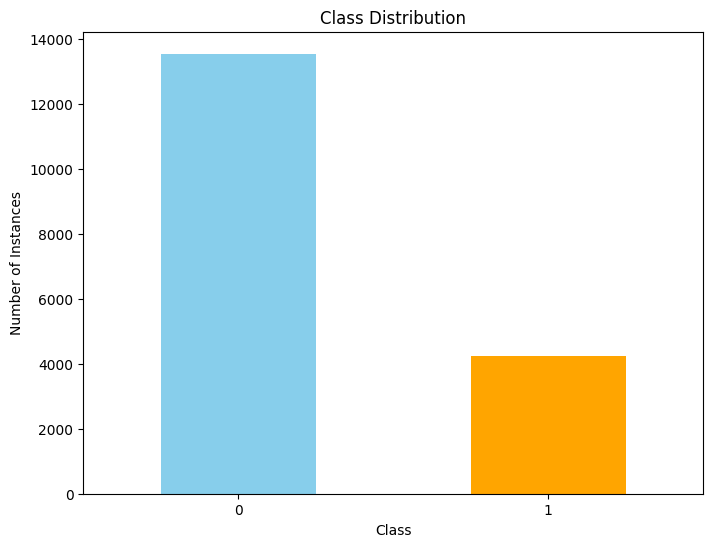

In [70]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

#### Visualize the Test Dataset

In [71]:
test_df.head()

,comment,hate_speech,lemmatized_comment
15742,any fucking person can be an asshole and you’r...,1,any fuck person can be an asshole and you ’ re...
5313,yep their bots just auto banning so many peopl...,0,yep their bots just auto ban so many people fr...
22136,her friend did tell her and she still decided ...,0,her friend do tell her and she still decide to...
10979,i had a thought when some people were being st...,0,i have a think when some people be be stupid a...
4420,given he’s a dark skinned guy with a foreign a...,0,give he ’ s a dark skin guy with a foreign acc...


In [72]:
X_test = test_df['lemmatized_comment']
y_test = test_df['hate_speech']

In [73]:
class_distribution = y_test.value_counts()

print("Class Distribution:")
print(class_distribution)

Class Distribution:
hate_speech
0    3389
1    1057
Name: count, dtype: int64


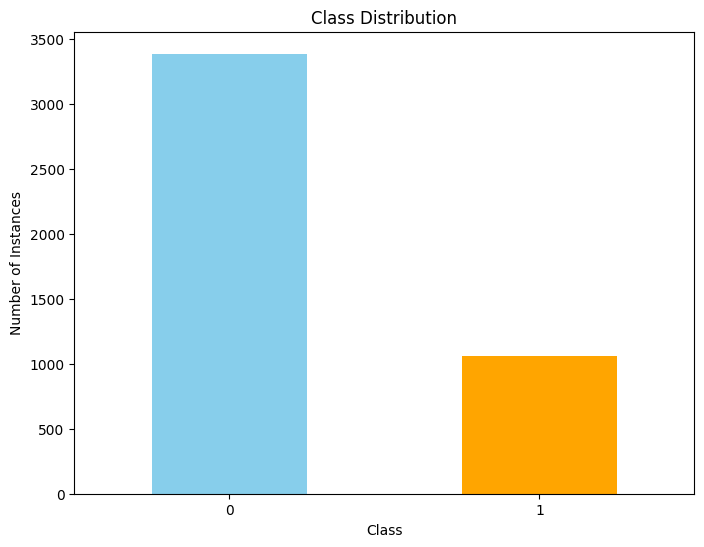

In [74]:
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

#### Save the train and test datasets

In [75]:
train_df.to_csv('/content/drive/MyDrive/Train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Test.csv', index=False)
print("Files saved")

Files saved


## Deep Learning Model

In [76]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [77]:
Train = pd.read_csv('/content/drive/MyDrive/Train.csv')
Train.head()

,comment,hate_speech,lemmatized_comment
0,lack of confidence what am i talking about you...,0,lack of confidence what be i talk about you as...
1,it also claims that riot prioritizes core gam...,0,it also claim that riot prioritize core gamers...
2,insert never go full retard clip here,1,insert never go full retard clip here
3,explaining but a man does it so it must be evi...,0,explain but a man do it so it must be evil shi...
4,that is only if you imagine waid is willing to...,0,that be only if you imagine waid be will to bl...


In [78]:
Test = pd.read_csv('/content/drive/MyDrive/Test.csv')
Test.head()

,comment,hate_speech,lemmatized_comment
0,any fucking person can be an asshole and you’r...,1,any fuck person can be an asshole and you ’ re...
1,yep their bots just auto banning so many peopl...,0,yep their bots just auto ban so many people fr...
2,her friend did tell her and she still decided ...,0,her friend do tell her and she still decide to...
3,i had a thought when some people were being st...,0,i have a think when some people be be stupid a...
4,given he’s a dark skinned guy with a foreign a...,0,give he ’ s a dark skin guy with a foreign acc...


In [79]:
X_train = Train['lemmatized_comment'].tolist()
X_test = Test['lemmatized_comment'].tolist()
y_train = Train['hate_speech'].values
y_test = Test['hate_speech'].values

#### Split into Train and Validation Dataset

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Create a custom dataset class for text classification

#### This is a custom dataset class that helps organize reddit comments and their sentiments for our BERT model. It takes care of tokenizing the text, handling the sequence length, and providing a neat package with input IDs, attention masks, and labels for our model to learn from.

In [81]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

### Build custom BERT classifier

#### Our BERT Classifier takes in some input IDs and attention masks, and runs them through BERT and the extra layers we added. The classifier returns our output as class scores.We will then add a dropout layer to keep things in check and a linear layer to help us classify text.

In [82]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

### Define Train method

#### The train() function takes the model, data loader, optimizer, scheduler, and device as its trainees. The function puts the model into training mode and then runs through each batch of data from the data loader. For each batch, it clears the optimizer’s gradients, gets the input IDs, attention masks, and labels, and feeds them to the model.

In [83]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

### Define Evaluation menthod

In [84]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    class_report = classification_report(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='weighted')
    recall = recall_score(actual_labels, predictions, average='weighted')
    f1 = f1_score(actual_labels, predictions, average='weighted')

    return accuracy, class_report, conf_matrix, precision, recall, f1

### Define Prediction method

In [85]:
def predict(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "contains hate speech" if preds.item() == 1 else "does not contain hate speech"

### Define Model Parameters

In [86]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 64
num_epochs = 15
learning_rate = 2e-5

### Initialize tokenizer, dataset, and data loader

In [87]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [88]:
# Train Dataset
train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, max_length)

# Test Dataset
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, max_length)

# Validation Dataset
val_dataset = TextClassificationDataset(X_val, y_val, tokenizer, max_length)

In [89]:
# Train Data Loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test Data Loader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Validation Data Loader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

### Loading the Bert Model and setup the device

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

### Set up Early Stopping

In [91]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, delta=0.001)
best_val_accuracy = 0

### Set up optimizer and learning rate scheduler

In [92]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Model Training

#### Given the significant computational demands of BERT, We've decided to limit the model training to just 10 epochs. Additionally, We've implemented early stopping with a patience of 2, considering the relatively low number of epochs.Furthermore, We've incorporated a learning rate reduction strategy, reducing the learning rate by a factor of 0.1 during training.

In [93]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model,train_dataloader,optimizer,scheduler,device)
        accuracy, report, matrix, precision, recall, f1 = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(report)

        # Early Stopping Check
        early_stopping(accuracy)
        if early_stopping.early_stop:
          print("Early stopping")
          break

        # Learning Rate Reduction
        if accuracy > best_val_accuracy:
          best_val_accuracy = accuracy
        else:
          for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 0.1

print("Training complete.")

Epoch 1/15
Validation Accuracy: 0.9078
Precision: 0.9072
Recall: 0.9078
F1 Score: 0.9075
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2710
           1       0.81      0.80      0.80       847

    accuracy                           0.91      3557
   macro avg       0.87      0.87      0.87      3557
weighted avg       0.91      0.91      0.91      3557

Epoch 2/15
Validation Accuracy: 0.9092
Precision: 0.9084
Recall: 0.9092
F1 Score: 0.9087
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2710
           1       0.82      0.79      0.81       847

    accuracy                           0.91      3557
   macro avg       0.88      0.87      0.87      3557
weighted avg       0.91      0.91      0.91      3557

Epoch 3/15
Validation Accuracy: 0.9010
Precision: 0.9028
Recall: 0.9010
F1 Score: 0.9018
              precision    recall  f1-score   support

           0       0.94 

## Evaluate Model

In [94]:
accuracy, report, matrix, precision, recall, f1 = evaluate(model, test_dataloader, device)

In [95]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Validation Accuracy: 0.8923
Precision: 0.8976
Recall: 0.8923
F1 Score: 0.8942


### Classification Report

In [96]:
print(report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3389
           1       0.75      0.83      0.79      1057

    accuracy                           0.89      4446
   macro avg       0.85      0.87      0.86      4446
weighted avg       0.90      0.89      0.89      4446



### Confusion Matrix

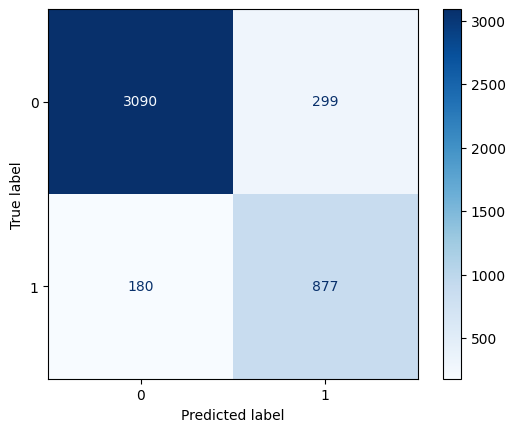

In [97]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Based on the evaluation results of the BERT model, we have surpassed our benchmark scores. Our accuracy and F1-score for hate speech prediction have improved significantly, reaching 89% accuracy and an F1-score of 78%, compared to our previous benchmark of 82% accuracy and 66% F1-score in our Machine Learning model.


### Save the Model

In [98]:
torch.save(model.state_dict(), "/content/drive/MyDrive/bert_classifier.pth")

## Testing the Model

In [99]:
test_text = "You ever fuck a bitch and she start to cry?"
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

You ever fuck a bitch and she start to cry?
Predicted sentiment: contains hate speech


In [100]:
test_text = " I hate Disneyland. It's fucking waste of money"
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

 I hate Disneyland. It's fucking waste of money
Predicted sentiment: does not contain hate speech


In [101]:
test_text = " we dont trust these niggas all these bitches "
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

 we dont trust these niggas all these bitches 
Predicted sentiment: contains hate speech


In [102]:
test_text= "The new restaurant in town has amazing food and great service."
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

The new restaurant in town has amazing food and great service.
Predicted sentiment: does not contain hate speech


In [103]:
test_text= "Don't trust any of these bitches"
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

Don't trust any of these bitches
Predicted sentiment: contains hate speech


In [104]:
test_text= "The food here tastes like shit"
sentiment = predict(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

The food here tastes like shit
Predicted sentiment: does not contain hate speech
